# Integrated gradients (IG)
Implementing the algorithm and trying to get an intuition of why/how it works

## References
- [The original paper](https://arxiv.org/pdf/1703.01365.pdf)
- [Previous work on path methods](https://link.springer.com/article/10.1007/s001820400173)
- [An investigation on the baseline choice](https://distill.pub/2020/attribution-baselines/)

## Toy example

Lets build a simple model to play around with the integrated gradients algorithm. Skip to the next section for a discussion on integrated gradients.

The class below represents a trained binary logistic regression classifier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Logistic:
    """
    Class that represents a trained binary logistic regression model
    :params w: (np.array) weights of the model. Must match the number of features
    :params b: (scalar) bias of the model
    """
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def fobj(self, X):
        """
        Computes the sigmoid function at X (process multiple inputs at once)
        .. math::
            f(X) : \mathbb{R}^{m,n} \to \mathbb{R}^m = \frac{1}{1 + \exp(-Xw - b)}
        """
        return 1 / (1 + np.exp(-np.matmul(X, self.w) - self.b))
    
    def gobj(self, X):
        """
        Computes the gradient of the sigmoid function at X
        .. math::
            \nabla f(X) : \mathbb{R}^{m,n} \to \mathbb{R}^{m,n} = (1 - f(X)) \odot f(X) \odot w^t
        
        where $\odot$ denotes the Hadamard (element-wise) product
        """
        f = self.fobj(X)
        return ((1 - f) * f)[:, None] * self.w
    

Lets define some arbitrary weights and bias for the sake of this example. In a real world scenario, this would be a trained model.

In [3]:
model = Logistic(np.array([10.0, -1.0]), -0.05)

Reference and baseline input

In [4]:
x_t, x_b = np.array([[0.5, -0.5]]), np.zeros((1, 2))
x_t, x_b

(array([[ 0.5, -0.5]]), array([[0., 0.]]))

Model classifies $x_b$ as class 0 and $x_t$ as class 1

In [5]:
model.fobj(x_b), model.fobj(x_t)

(array([0.4875026]), array([0.99572207]))

In [6]:
model.gobj(x_b), model.gobj(x_t)

(array([[ 2.49843815, -0.24984382]]), array([[ 0.04259625, -0.00425962]]))

Validating that passing multiple inputs at once works

In [7]:
X_b, X_t = x_b.repeat(5, axis=0), x_t.repeat(5, axis=0)

In [8]:
model.fobj(X_b), model.fobj(X_t)

(array([0.4875026, 0.4875026, 0.4875026, 0.4875026, 0.4875026]),
 array([0.99572207, 0.99572207, 0.99572207, 0.99572207, 0.99572207]))

In [9]:
model.gobj(X_b), model.gobj(X_t)

(array([[ 2.49843815, -0.24984382],
        [ 2.49843815, -0.24984382],
        [ 2.49843815, -0.24984382],
        [ 2.49843815, -0.24984382],
        [ 2.49843815, -0.24984382]]),
 array([[ 0.04259625, -0.00425962],
        [ 0.04259625, -0.00425962],
        [ 0.04259625, -0.00425962],
        [ 0.04259625, -0.00425962],
        [ 0.04259625, -0.00425962]]))

## Integrated gradients

IG is a specialized class of so-called _path methods_ , which stem from game theory (see Friedman 2004). The authors claim that path methods are the only type of methods that satisfy a set of axioms, which they argue are crucial for interpretation techniques. For more details, please read the original paper. The general formula of integrated gradients on a path $\gamma(\alpha) : \mathbb{R} \to \mathbb{R}^n$ is stated as follows:

$$ IG(x)_i = \int_0^1 \frac{\partial f(\gamma(\alpha))}{\partial \gamma(\alpha)_i}\frac{\partial\gamma(\alpha)_i}{\partial\alpha} d\alpha $$

where $i$ denotes the $i^\text{th}$ input feature $x_i \in \mathbb{R}$ of a trained model $f(x; \theta): \mathbb{R}^n \to [0, 1]$, where $\theta$ are trained parameters (omitted from now on). Also note that the derivative of $f$ in the integral is with respect to $x$. $\gamma(\alpha)$ is simply an $x$ value that will be taken along the trajectory.

IG is the specific case of path method where $\gamma(\alpha)$ is the linear trajectory
$$ \gamma(\alpha) = x_b + \alpha \cdot (x_t - x_b) $$
where $x_b \in \mathbb{R}^n$, a baseline input, and $x_t \mathbb{R}^n$, the target input for which we want attribution scores. Note that $\gamma(0) = x_b$ and $\gamma(1) = x_t$: all the others values are interpolated along the straight line between $x_b$ and $x_t$. This baseline is an artifact of this method and is used to represent the absence of a/all the features in such a way that the $\mathrm{IG}$ attributions can be entierely affected to the target.

By substituion, we obtain the attribution score for $x_i$:
$$ \mathrm{IG}(x_t)_i = (x_t - x_b)_i \cdot \int_0^1 \frac{\partial f(x_b + \alpha(x_t - x_b))}{\partial x_i} d\alpha $$

Lets look at this equation piece by piece.

### Breaking down the equation
Without knowing much about path methods, we can recognize that IG is a form of **[line integral](http://tutorial.math.lamar.edu/Classes/CalcIII/LineIntegralsVectorFields.aspx)**. 
First, note that the gradient of the model $\nabla f(x) : \mathbb{R}^n \to \mathbb{R}^n$ is a vector field: for each input vector $x$, we have an output vector of the derivative with respect to each feature $x_i$.

The integral of any vector field $F(x)$ along a curve $C$ can be parametrized by a scalar $\alpha$ such that we can obtain:
$$ \int_C F(x) \cdot dx =  \int_0^1 F(\gamma(\alpha))^T \frac{\partial \gamma(\alpha)}{\partial \alpha} d\alpha $$
where $\gamma \in \mathbb{R}^n$ and $\alpha \in \mathbb{R}$ and $^T$ denotes a transpose operation (dot product).

If we set 
$$F(x) = \nabla f(x)_i : \mathbb{R}^n \to \mathbb{R}$$
that is, we only take the derivative of our model at $x$ with respect to $x_i$, than only the $i^\text{th}$ component of the dot product will be non null. We also note that for the linear trajectory $\gamma(\alpha)$ defined above, we have
$$ \frac{\partial \gamma(\alpha)}{\partial \alpha} = x_t - x_b \in \mathbb{R}^n $$

By plugging back into the integral, you should exactly get the $\mathrm{IG}_i$. integral.

Finally, we can come full circle by citing the [fundamental theorem of line integrals](http://tutorial.math.lamar.edu/Classes/CalcIII/FundThmLineIntegrals.aspx)
$$ \int_C \nabla f \cdot dx = f(x_t) - f(x_b) $$
where $C$ is the trajectory parametrized by $\gamma(\alpha)$. Looking back at $\mathrm{IG}_i$, we can identify that 
$$ \sum_i \mathrm{IG}(x_t)_i = \int_C \nabla f \cdot dx = f(x_t) - f(x_b) $$

This is great because we now have a way to validate that our implementation works.


### A bit of intuition
Drawing the parallel with line integrals allows us to better understand what the integrated gradients method is doing.

In a nutshell, it tries to measure which part of $f(x_t) - f(x_b)$ is **only caused by $x_i$**. We can interpret the integral as the cumulative variation produced in the output of the model **only** by the feature $x_i$ if we were to move from $x_b$ to $x_t$.

In physics, line integrals are used to compute the _work_ , for instance if you want to lift a crate subject to a gravitional (vector) field.

You might wonder why we are not simply looking at the gradients at the endpoints of the trajectory.

This highlights the importance of the baseline, which is used in IG to represent the absence of a/all features. 

## Implementation
Noting that:
1. The derivatives should be evaluated on all features at once, but the integrals should be computed on each individual features independently
2. By making use of vectorized operations, we can directly compute the $\mathrm{IG} \in \mathbb{R}^n$ vector at once rather then by component. First, note the Jacobian matrix $J(X) : \mathbb{R}^{m,n} \to \mathbb{R}^{m,n}$
    $$ J(X) = \begin{bmatrix} \nabla f(x^{(1)}) \\ \nabla f(x^{(2)}) \\ \vdots \\ \nabla f(x^{(m)}) \end{bmatrix} $$
    where $X$ is a matrix of $m$ $x$ observations (e.g. interpolated values along the trajectory). Then we can write
    $$ \mathrm{IG}(x_t) = (x_t - x_b) \odot \text{int}(J(X_\alpha))$$
    
    where $\odot$ is the Hadamard (element-wise) product, $X_\alpha$ is the matrix of $m$ interpolated values and $\text{int}()$ is a numerical approximation of the integral (e.g. np.trapz) along the examples/first dimension such that the output of $\text{int}() \in \mathbb{R}^n$.
we can make a fairly efficient implementation.

In [10]:
def ig(model, x_t, x_b, n_steps=300):
    """
    Integrated gradients algorithm
    .. math::
        \mathrm{IG}_i = (x_t - x_b)_i \cdot \int_0^1 \frac{\delta f(x_b + \alpha(x_t - x_b))}{\delta x_i} d\alpha
    The IG score of the ith feature is the integral of the partial derivative of f with respect to the ith feature
    on a straight line between the baseline and the target (parametrized by alpha).
        
    :param gobj: (function) function that computes the gradient for multiple inputs (m, n)
    :param x_t: (np.array) reference input
    :param x_b: (np.array) baseline input
    :param n_steps: (int) number of interpolation steps to use
    :return: (np.array) x_t integrated gradients attributions
    """
    n_steps = int(n_steps) if not isinstance(n_steps, int) else n_steps
    delta = x_t - x_b  # (1, n)
    steps = np.linspace(0, 1, n_steps)[:, None]  # (n_steps, 1)
    # Create a matrix of interpolated inputs
    X_i = x_b + steps * delta  # (n_steps, n)
    # Get the gradients for all features for each inputs
    grads = model.gobj(X_i)  # (n_steps, n)
    # Integrate along the inputs dimension for each feature
    int_grad = np.trapz(grads, steps, axis=0)  # (1, n)
    ig = delta * int_grad  # (1, n)
    # I will return the gradients and the steps to display other stuff
    return ig, grads, steps

The algorithm correctly uncovers that $x_1$ is more important because $w_1$ has a bigger magnitude

In [53]:
attrib, grads, steps = ig(model, x_t, x_b, 1e3)
attrib

array([[0.46201768, 0.04620177]])

As mentioned previously, the sum of the attribution scores should be equal to the difference between the model outputs.

In [12]:
attrib.sum(), (model.fobj(x_t) - model.fobj(x_b))[0]

(0.5082194446236203, 0.5082194710645056)

Lets plot the function values and gradients on some grid

In [13]:
n_vals = 501
vals = np.linspace(-0.6, 0.6, n_vals)

In [14]:
x1, x2 = np.meshgrid(vals, vals)

Convert the mesh values into $(m, n)$ format for our model

In [15]:
X = np.c_[x1.flatten(), x2.flatten()]
X.shape

(251001, 2)

Convert outputs to mesh size

In [16]:
f, grad = model.fobj(X).reshape(x1.shape), model.gobj(X).reshape(*x1.shape, -1)
f.shape, grad.shape

((501, 501), (501, 501, 2))

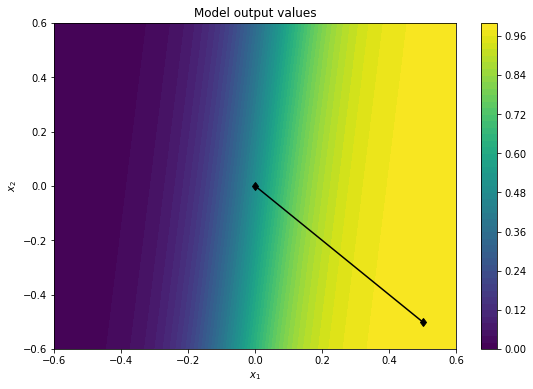

In [35]:
fig, ax = plt.subplots(figsize=(9, 6))
cmap = ax.contourf(x1, x2, f, levels=50)
fig.colorbar(cmap)
ax.plot(*np.r_[x_b, x_t].T, "k-d")
ax.set_title("Model output values")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.show()

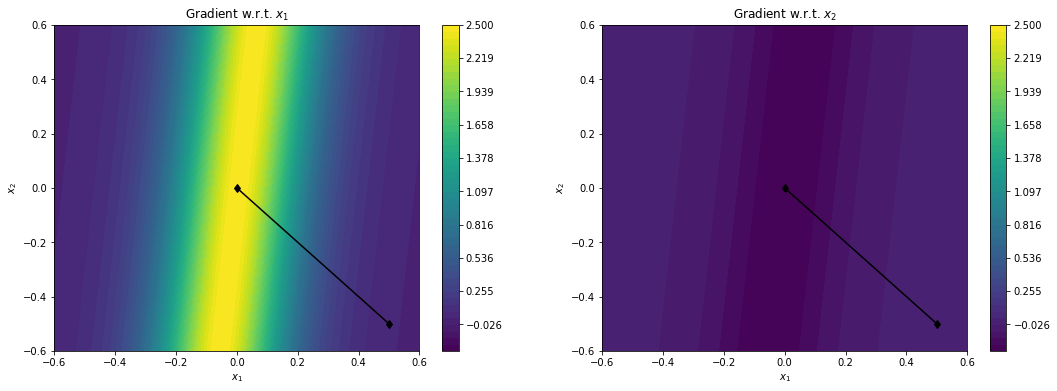

In [18]:
grad_levels = np.linspace(grad.flatten().min(), grad.flatten().max(), 50)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
cmap = ax1.contourf(x1, x2, grad[:, :, 0], levels=grad_levels)
fig.colorbar(cmap, ax=ax1)
ax1.plot(*np.r_[x_b, x_t].T, "k-d")
ax1.set_title("Gradient w.r.t. $x_1$")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
cmap = ax2.contourf(x1, x2, grad[:, :, 1], levels=grad_levels)
fig.colorbar(cmap, ax=ax2)
ax2.plot(*np.r_[x_b, x_t].T, "k-d")
ax2.set_title("Gradient w.r.t. $x_2$")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
plt.show()

In [19]:
skip_size = 40
xx1, xx2, xxgrad = (
    x1[::skip_size, ::skip_size],
    x2[::skip_size, ::skip_size],
    grad[::skip_size, ::skip_size]
)

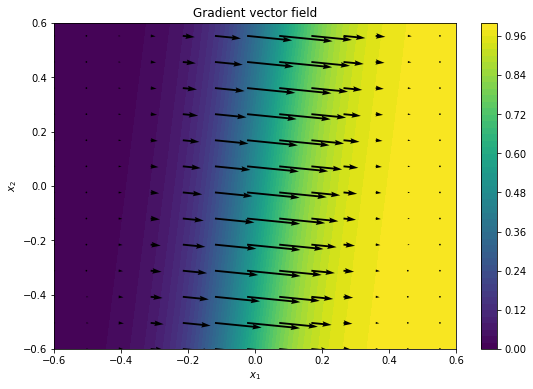

In [34]:
fig, ax = plt.subplots(figsize=(9, 6))
cmap = plt.contourf(x1, x2, f, levels=50)
plt.quiver(xx1, xx2, xxgrad[:, :, 0], xxgrad[:, :, 1])
fig.colorbar(cmap)
ax.set_title("Gradient vector field")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.show()

Lets do our own cumulative trapz to show the cumulative gradient contribution
$$ \int_a^b f(x) dx \approx (b - a) \cdot \frac{f(a) + f(b)}{2} $$

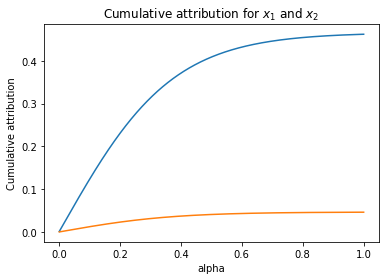

In [49]:
integral = (x_t - x_b) * ((steps[1:, :] - steps[:-1, :]) * (grads[1:, :] + grads[:-1, :]) / 2).cumsum(axis=0)
f, ax = plt.subplots()
ax.plot(steps[1:], integral[:, 0])
ax.plot(steps[1:], integral[:, 1])
ax.set_title("Cumulative attribution for $x_1$ and $x_2$")
ax.set_xlabel("alpha")
ax.set_ylabel("Cumulative attribution")
plt.show()

Just looking at the gradient at the endpoints of the trajectories is not enough to explain the feature importance.

In [23]:
grads[0, :], grads[-1, :]

(array([ 2.49843815, -0.24984382]), array([ 0.04259625, -0.00425962]))